<a href="https://colab.research.google.com/github/eladses/sudoku-solver/blob/main/sudoku_solver_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**in development!! not done**

sudoku solver using openCV, pytesseract and py-sudoku to find solution of sudoku from image

---

**How To Use**

1. upload image
2. run imports
3. run functions
4. run algorethms

---

**How It Works**

1. extraction board
  1. finding biggest square
  2.
2. filtering cells
  1.
  2.


# Imports

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install py-sudoku
!pip install opencv-python

In [ ]:
import numpy as np
import cv2
import math

from imutils import contours
from google.colab.patches import cv2_imshow

from sudoku import Sudoku

from PIL import Image
import requests

import pytesseract
# pytesseract.pytesseract.tesseract_cmd = (
#     r'/usr/bin/tesseract'
# )

from tensorflow import keras
import matplotlib.pyplot as plt

# Upload

In [ ]:
sudoku_url = 'https://i.redd.it/y4f37ifec7aa1.jpg'
img = np.array(Image.open(requests.get(sudoku_url, stream=True).raw))[:, :, ::-1].copy()

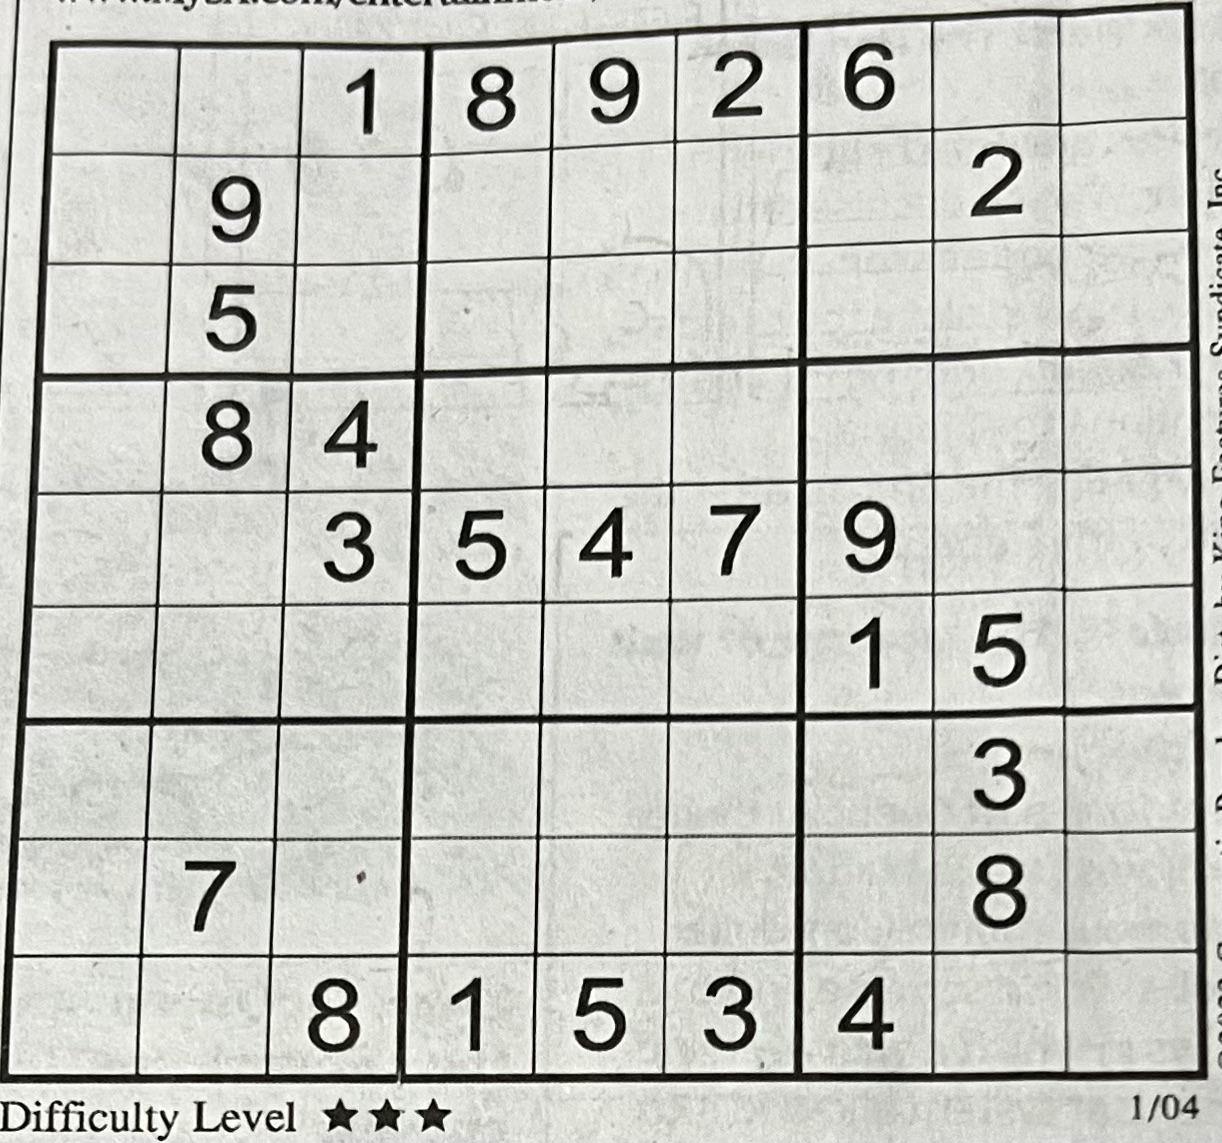

In [45]:
cv2_imshow(img)

# computer vision functions

In [ ]:
def get_board(img):
    """corpes the board from image

    Args:
      img (cv2 image format) - the image of the sudocu

    Returns:
      board_img (cv2 image format) - the board corped for the image
    """
    gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    ret,thresh = cv2.threshold(gray,100,255,cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    if len(contours) != 0:

        # find the biggest countour (c) by the area
        c = max(contours, key = cv2.contourArea)
        epsilon = 0.1 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points
        # draw the biggest contour (c) in green


    def order_points(pts):
        '''Rearrange coordinates to order:
          top-left, top-right, bottom-right, bottom-left'''
        rect = np.zeros((4, 2), dtype='float32')
        pts = np.array(pts)
        s = pts.sum(axis=1)
        # Top-left point will have the smallest sum.
        rect[0] = pts[np.argmin(s)]
        # Bottom-right point will have the largest sum.
        rect[2] = pts[np.argmax(s)]

        diff = np.diff(pts, axis=1)
        # Top-right point will have the smallest difference.
        rect[3] = pts[np.argmin(diff)]
        # Bottom-left will have the largest difference.
        rect[1] = pts[np.argmax(diff)]
        # return the ordered coordinates
        return rect.astype('int').tolist()


    pt_A,pt_B,pt_C,pt_D=order_points([corners[0][0],corners[1][0],corners[2][0],corners[3][0]])

    # Here, I have used L2 norm. You can use L1 also.
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))


    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))

    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([[0, 0],
                            [0, maxHeight - 1],
                            [maxWidth - 1, maxHeight - 1],
                            [maxWidth - 1, 0]])

    # Getting the homography.
    M = cv2.getPerspectiveTransform(input_pts,output_pts)

    return cv2.warpPerspective(img,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

In [ ]:
def remove_small_contours(img,small_area=1000):
  """this founction remove small countours from the image. used to remove the numbers

  Args:
    img (cv2 image format)

  Returns:
    img (cv2 image format)
  """

  mask = np.zeros(img.shape[:2], dtype=img.dtype)
  cnts, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for c in cnts:
      area = cv2.contourArea(c)
      if area < small_area:
        x, y, w, h = cv2.boundingRect(c)
        cv2.drawContours(mask, [c], 0, (255), -1)

  return img-mask


def get_cells(board_img,board_lines_mask):
    """corpes the cells from the board

    Args:
      board_img (cv2 image format) - board
      board_lines_mask (cv2 image format) - board lines

    Returns:
      board_img (cv2 image format) - the board corped for the image
    """

    invert = 255 - board_lines_mask
    cnts,_ = cv2.findContours(invert, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # (cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

    newBoard = board.copy()
    rectangles=[]
    for c in cnts:
      if(cv2.contourArea(c)<0**2): continue
      x,y,w,h = cv2.boundingRect(c)
      if(w<board_img.shape[0]/18 or h<board_img.shape[1]/18): continue
      # print(cv2.boundingRect(c))
      rectangles.append(cv2.boundingRect(c))
    # for rectangle in rectangles:
    #   cv2_imshow(board[rectangle[0]:(rectangle[0] + rectangle[2]),rectangle[1]:(rectangle[1]+ rectangle[3])])

    a,b,_=board_img.shape

    rectangles = sorted(rectangles, key=lambda x: int((int((x[1])/int(a/18))+1)/2) * 100 + int((int((x[0])/int(b/18))+1)/2))
    # print(rectangles)
    # for i in range(len(rectangles)):
      # rect = rectangles[i]
      # print(i,rect,end=": ")
      # print(int(rect[0]/a*9)/100+int(rect[1]/b*9))
    # i=0
    # for c in rectangles:
    #   x,y,w,h=c
    #   cv2.rectangle(newBoard, (x, y), (x + w, y + h), (255,0,0), 1)
    #   cv2.putText(newBoard, str(i), (x,y+h),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2,cv2.LINE_AA)
    #   i+=1

    # cv2_imshow(newBoard)

    if len(rectangles)!=81:
      return

    return rectangles




In [ ]:
def get_cell_content(cell):

  cell_copy = cell.copy()
  # cell_copy = cv2.resize(cell_copy, (0, 0), fx=2, fy=2)
  gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray,(9,9),0)
  ret,thresh1 = cv2.threshold(blur,127,255,cv2.THRESH_BINARY_INV)

  contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL,
                                                  cv2.CHAIN_APPROX_NONE)
  if(len(contours)==0): return None

  is_contain_something = False
  max_contour = max(contours, key=cv2.contourArea)
  for cnt in contours:
    if(cv2.contourArea(cnt)<cell_copy.shape[0]*cell_copy.shape[0]/100):
      cv2.fillPoly(thresh1, pts = [cnt], color=(0,0,0))
      continue
    else:
      is_contain_something = True
  if not is_contain_something: return None

  x, y, w, h = cv2.boundingRect(max_contour)

  # Drawing a rectangle on copied image
  # rect = cv2.rectangle(cell_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

  # Cropping the text block for giving input to OCR
  cropped = (255-thresh1)[y:y + h, x:x + w]

  # Apply OCR on the cropped image
  imgs = [cell,gray,blur,255-thresh1,cropped]
  num = "0"
  custom_config = r'--oem 1 --psm 10 -c tessedit_char_whitelist=123456789'
  # for im in imgs:
  #   cv2_imshow(im)
  #   new_num = pytesseract.image_to_string(im, config = custom_config)
  #   print(new_num)
  #   if new_num and new_num.strip()!="":
  #     num = new_num.strip()
  # print("selected:",num)
  # cv2_imshow(cell)
  text = pytesseract.image_to_string(255-thresh1, config = custom_config)
  # text1 = pytesseract.image_to_string(cropped, config = custom_config)
  # print(text,":-:",text1)
  if text.strip(): return int(text.strip())
  else: return 9


# sudoku functions

In [ ]:
puzzle = Sudoku(3).difficulty(0.5)
def load_sudoku(board):
  [board[i:i+9] for i in range(0, len(board), 9)]
  return Sudoku(3, 3, board=board)
def solve_sudoku(sudoku):
  return sudoku.solve()

In [ ]:
game = load_sudoku(puzzle.board)
print(game.board)
print(solve_sudoku(game).board)
print(solve_sudoku(game))

# Program

In [ ]:
# show image
cv2_imshow(img)

In [ ]:
# crop board
board=get_board(img)
cv2_imshow(board)

In [ ]:
# get board lines
board_gray = cv2.cvtColor(board, cv2.COLOR_RGB2GRAY)
_,board_thresh = cv2.threshold(board_gray,150,255,cv2.THRESH_BINARY_INV)
board_clean = remove_small_contours(board_thresh,board_thresh.shape[0]*board_thresh.shape[1]/9)

kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(board_clean, kernel, iterations=1)
cv2_imshow(dilated_mask)

In [ ]:
rectangles=get_cells(board,dilated_mask)

cells=[board[y:y+ h,x:x + w] for (x,y,w,h) in rectangles]

In [ ]:
board_copy=board.copy()
for i in range(9):
  cv2.line(board_copy,(0,int(board_copy.shape[0]/9*i+board_copy.shape[0]/18)),(board_copy.shape[1],int(board_copy.shape[0]/9*i+board_copy.shape[0]/18)),(0,0,255),3)
  cv2.line(board_copy,(int(board_copy.shape[1]/9*i+board_copy.shape[1]/18),0),(int(board_copy.shape[1]/9*i+board_copy.shape[1]/18),board_copy.shape[0]),(0,0,255),3)
i=0
for c in rectangles:
  x,y,w,h=c
  cv2.rectangle(board_copy, (x, y), (x + w, y + h), (255,0,0), 1)
  cv2.putText(board_copy, str(i), (x,y+20),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2,cv2.LINE_AA)
  i+=1
cv2_imshow(board_copy)

# for cell in cells:
#   cv2_imshow(cell)

In [ ]:
cells_gray=[cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY) for cell in cells]
# for cell in cells:

# cells_resizeds=[cv2.resize(gray,(28,28)) for gray in cells_gray]
# cells_resizeds=[cv2.threshold(resized,127,255,cv2.THRESH_BINARY_INV)[1]/255 for resized in cells_resizeds]

In [ ]:
puzzle_board=list([get_cell_content(cell) for cell in cells])
# for i in range(81):
#   cell=cells[i]
#   # gray=cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
#   # (thresh, bw_img) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#   # cell_BGR = cv2.cvtColor(cell, cv2.COLOR_BGR2RGB)
#   # im_pil = Image.fromarray(cell_BGR)
#   cell_text = get_cell_content(cell)
#   if cell_text != None:
#     cv2_imshow(cell)
#     print("num:" + str(cell_text))

In [ ]:
print(puzzle_board)
print([puzzle_board[i:i+9] for i in range(0, len(puzzle_board), 9)])
game = load_sudoku([puzzle_board[i:i+9] for i in range(0, len(puzzle_board), 9)])
sudoku_solution = solve_sudoku(game).board
print(sudoku_solution)

In [ ]:
sudoku_solution_board=[]
for item in sudoku_solution:
  sudoku_solution_board  += item
print(sudoku_solution_board, len(sudoku_solution_board))

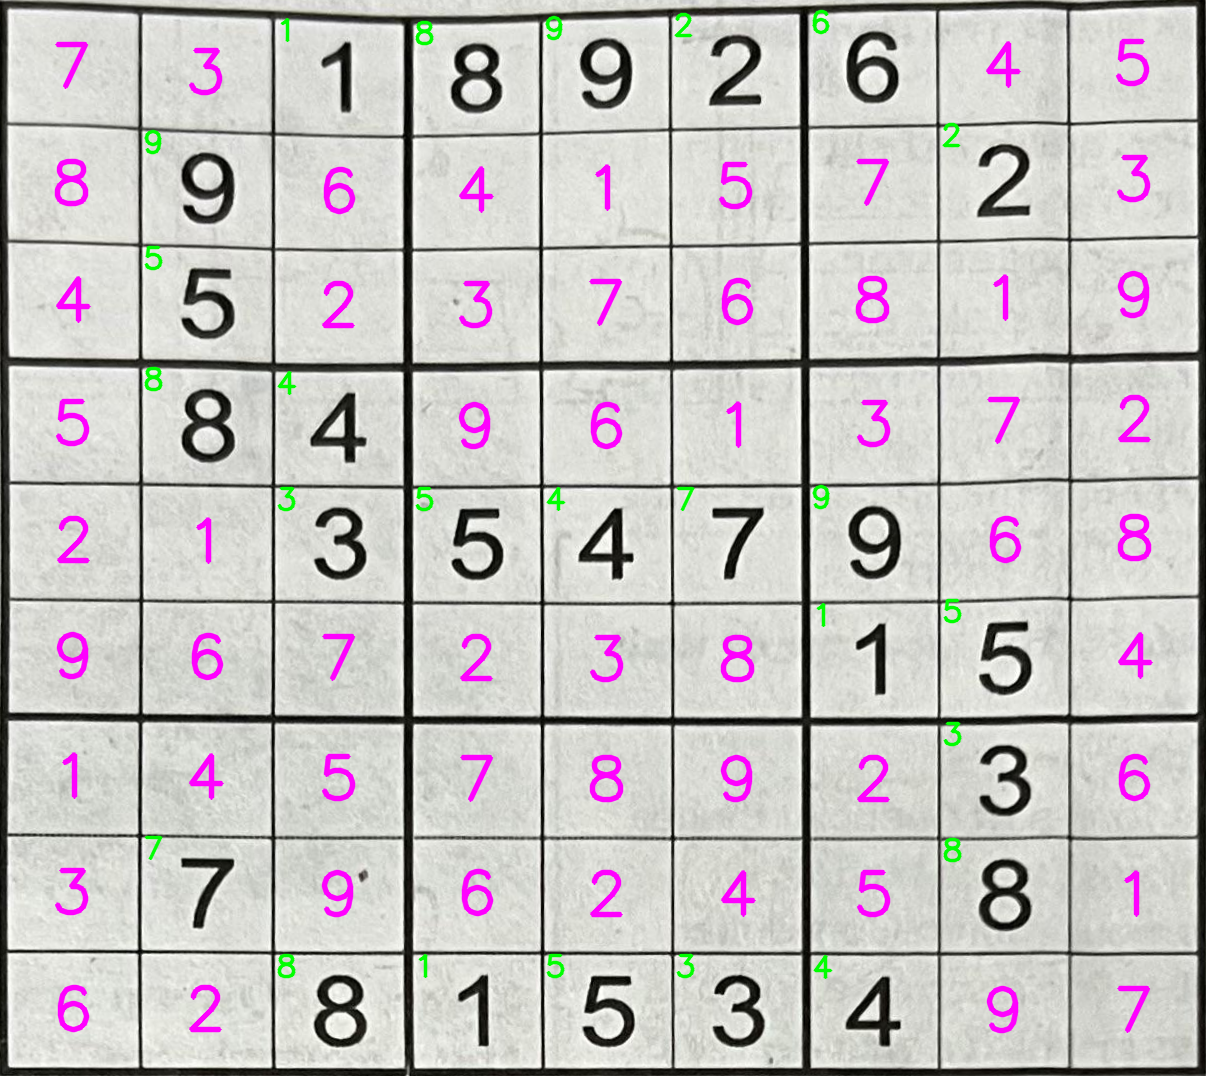

In [44]:
board_copy=board.copy()
i=0
for c in rectangles:
  x,y,w,h=c
  # cv2.rectangle(board_copy, (x, y), (x + w, y + h), (255,0,0), 1)
  if (puzzle_board[i]!=None):
    cv2.putText(board_copy, str(sudoku_solution_board[i]), (x,y+20),cv2.FONT_HERSHEY_SIMPLEX,1 ,(0,255,0),2 ,cv2.LINE_AA)
  else:
    cv2.putText(board_copy, str(sudoku_solution_board[i]), (x + int(w/3), y + int(2*h/3)),cv2.FONT_HERSHEY_SIMPLEX,2,(255,0,255) ,3 ,cv2.LINE_AA)
  i+=1
cv2_imshow(board_copy)